In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(PATH, parse_dates=True)

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1962-01-02,6.4130,6.4130,6.3378,6.3378,467056,0
1,1962-01-03,6.3378,6.3963,6.3378,6.3963,350294,0
2,1962-01-04,6.3963,6.3963,6.3295,6.3295,314365,0
3,1962-01-05,6.3211,6.3211,6.1958,6.2041,440112,0
4,1962-01-08,6.2041,6.2041,6.0373,6.0870,655676,0


In [ ]:
df['Date'] = df['Date'].astype('datetime64[ns]')

# 1) Preprocessing Data

Since there aren't any missing values in other columns, we will not drop them for now.

**Add High Low ratio feature**

In [ ]:
df['HI_LO'] = df.High/df.Low

**Add Closing and Opening price relation feature**

In [ ]:
df['OP_CL'] = (df.Close-df.Open)/df.Open

**Drop unneccessary features**

In [ ]:
df = df.drop(['High', 'Low', 'OpenInt', 'Open'], axis=1)
df

,Close,Volume,DOW,HI_LO,OP_CL
Date,,,,,
1962-01-02,6.3378,467056,3,1.011865,-0.011726
1962-01-03,6.3963,350294,4,1.009230,0.009230
1962-01-04,6.3295,314365,2,1.010554,-0.010444
1962-01-05,6.2041,440112,0,1.020223,-0.018509
1962-01-08,6.0870,655676,1,1.027628,-0.018875
...,...,...,...,...,...
2017-11-30,153.9700,6473934,2,1.008688,0.002083
2017-12-01,154.7600,5527330,0,1.013779,0.002332
2017-12-04,156.4600,4664064,1,1.011156,0.005075


## 2.2 Adding Technical Indicators

As suggested in the paper, which presented the procedure we are trying to implement, to predict the price of stock we can use some technical indicators as features. Some of the suggested technical indicators from the paper are: Moving Average (SMA), Exponential Moving Average (EMA), Relative Strength Index (RSI), Weighted Moving Average (WMA), Standard Deviation (STD), Variance (VAR), Triple Moving Exponential (TRIX) and Rate of Change (ROC). Here we will calculate some of those technical indicators and add a few of our own.

### **Simple Moving Average** <br>

With window sizes: 7, 30 and 90

In [ ]:
df['SMA_3'] = df.Close.rolling(3).mean()
df['SMA_7'] = df.Close.rolling(7).mean()
df['SMA_30'] = df.Close.rolling(30).mean()
df['SMA_90'] = df.Close.rolling(90).mean()

### **Exponential Moving Average (EMA)** <br>
With time spans 7, 30 and 90

In [ ]:
df['EMA_3'] = df.Close.ewm(span=3, adjust=False).mean()
df['EMA_7'] = df.Close.ewm(span=7, adjust=False).mean()
df['EMA_30'] = df.Close.ewm(span=30, adjust=False).mean()
df['EMA_90'] = df.Close.ewm(span=90, adjust=False).mean()

### **Rolling Standard Deviation**

Window sizes: 7, 30 and 90


In [ ]:
df['STD_3'] = df.Close.rolling(3).std()
df['STD_7'] = df.Close.rolling(7).std()
df['STD_30'] = df.Close.rolling(30).std()
df['STD_90'] = df.Close.rolling(90).std()

### **Relative Strength Index (RSI)**



In [ ]:
def calculate_rsi(span):
  delta = df['Close'].diff()
  up = delta.clip(lower=0)
  down = -1*delta.clip(upper=0)
  ema_up = up.ewm(span=span, adjust=False).mean()
  ema_down = down.ewm(span=span, adjust=False).mean()
  rs = ema_up/ema_down
  return 100-(100/(1+rs))

In [ ]:
df['RSI_3'] = calculate_rsi(3)
df['RSI_7'] = calculate_rsi(7)
df['RSI_30'] = calculate_rsi(30)

### **Rate of Change (ROC)**

In [ ]:
def ROC(df, n):
  M = df.diff(n)
  N = df.shift(n)
  ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
  return ROC

In [ ]:
df['ROC_3'] = ROC(df['Close'], 3)
df['ROC_7'] = ROC(df['Close'], 7)
df['ROC_30'] = ROC(df['Close'], 30)

# 3) Splitting and Scaling Data

## 3.1 Scaling data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

**MinMax Scaling** <br>


In [ ]:
columns_to_scale = list(df.columns)
columns_to_scale.remove('DOW')
columns_to_scale.remove('Close')
columns_to_scale

['Volume',
 'HI_LO',
 'OP_CL',
 'SMA_3',
 'SMA_7',
 'SMA_30',
 'SMA_90',
 'EMA_3',
 'EMA_7',
 'EMA_30',
 'EMA_90',
 'STD_3',
 'STD_7',
 'STD_30',
 'STD_90',
 'RSI_3',
 'RSI_7',
 'RSI_30',
 'ROC_3',
 'ROC_7',
 'ROC_30']

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = df.copy()
scaler_close = MinMaxScaler(feature_range=(-1,1))
df_scaled['Close'] = scaler_close.fit_transform(df_scaled['Close'].values.reshape(-1,1))
for c in columns_to_scale:
  df_scaled[c] = scaler.fit_transform(df_scaled[c].values.reshape(-1,1))

## 3.2 Creating Labels

First we create a label for classification. We look at the differences between closing prices and if the price has grown we assign label 1. We will look at 4 different horizons of prediction. We will look at the end-of-day price and 3, 7 and 30 horizon prices. This means that if the price 3 days from the current day has increased from the current price, the label will be 1.

In [ ]:
df['CL_1'] = -df.Close.diff(periods=-1) > 0
df['CL_1'] = df['CL_1'].astype(int)
df['CL_3'] = -df.Close.diff(periods=-3) > 0
df['CL_3'] = df['CL_3'].astype(int)
df['CL_7'] = -df.Close.diff(periods=-7) > 0
df['CL_7'] = df['CL_7'].astype(int)
df['CL_30'] = -df.Close.diff(periods=-30) > 0
df['CL_30'] = df['CL_30'].astype(int)

Now we will create labels for regression. The regression label is the value of the clsoing price shifted for a certain number of days, based on the horizon value.

In [ ]:
df['REG_1'] = df.Close.shift(periods=-1)
df['REG_3'] = df.Close.shift(periods=-3)
df['REG_7'] = df.Close.shift(periods=-7)
df['REG_30'] = df.Close.shift(periods=-30)

Since we computed some moving averages and additional technical features we created Nan values at the beginning and end of the data series. Now we remove those Nan values and since the dataset is large enough this removal will not impact our quality of dataset.

In [ ]:
df = df.iloc[90:-30, ]
df_scaled = df_scaled.iloc[90:-30, ]
df.isna().sum()

Close     0
Volume    0
DOW       0
HI_LO     0
OP_CL     0
SMA_3     0
SMA_7     0
SMA_30    0
SMA_90    0
EMA_3     0
EMA_7     0
EMA_30    0
EMA_90    0
STD_3     0
STD_7     0
STD_30    0
STD_90    0
RSI_3     0
RSI_7     0
RSI_30    0
ROC_3     0
ROC_7     0
ROC_30    0
CL_1      0
CL_3      0
CL_7      0
CL_30     0
REG_1     0
REG_3     0
REG_7     0
REG_30    0
dtype: int64

## 3.3 Train/Test Split

Next we split the data into train and test datasets.

In [ ]:
cols = df.columns
inputs = list(cols[:-8])
labels = list(cols[-8:])
print(inputs,'\n', labels)

['Close', 'Volume', 'DOW', 'HI_LO', 'OP_CL', 'SMA_3', 'SMA_7', 'SMA_30', 'SMA_90', 'EMA_3', 'EMA_7', 'EMA_30', 'EMA_90', 'STD_3', 'STD_7', 'STD_30', 'STD_90', 'RSI_3', 'RSI_7', 'RSI_30', 'ROC_3', 'ROC_7', 'ROC_30'] 
 ['CL_1', 'CL_3', 'CL_7', 'CL_30', 'REG_1', 'REG_3', 'REG_7', 'REG_30']


In [ ]:
lenX = df.shape[0]
split = int(lenX*0.8)

In [ ]:
X_train = df_scaled.iloc[:split, ]
X_test = df_scaled.iloc[split:, ]

Now we divide the labels and the input values

In [ ]:
outputs = df[labels]
Y_train, Y_test = outputs[:split], outputs[split:]
X_train = X_train[inputs]
X_test = X_test[inputs]

# 4) Feature Selection



## 4.1 Random Forest Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

In [ ]:
all_features = list(X_train.columns)
all_features

['Close',
 'Volume',
 'DOW',
 'HI_LO',
 'OP_CL',
 'SMA_3',
 'SMA_7',
 'SMA_30',
 'SMA_90',
 'EMA_3',
 'EMA_7',
 'EMA_30',
 'EMA_90',
 'STD_3',
 'STD_7',
 'STD_30',
 'STD_90',
 'RSI_3',
 'RSI_7',
 'RSI_30',
 'ROC_3',
 'ROC_7',
 'ROC_30']

In [ ]:
def select_features(X_train, y_train, X_test, y_test, n):
  sel = SelectFromModel(RandomForestClassifier(n_estimators = n))
  sel.fit(X_train, y_train)
  selected_feat= X_train.columns[(sel.get_support())]
  importances = sel.estimator_.feature_importances_
  forest_importances = pd.Series(importances, index=all_features)
  fig, ax = plt.subplots()
  forest_importances.plot.bar( ax=ax)
  ax.set_title("Feature importances using MDI")
  ax.set_ylabel("Mean decrease in impurity")
  fig.tight_layout()


  return selected_feat

Index(['Volume', 'HI_LO', 'OP_CL', 'STD_3', 'STD_7', 'STD_30', 'STD_90',
       'RSI_3', 'RSI_7', 'RSI_30', 'ROC_3', 'ROC_7', 'ROC_30'],
      dtype='object')

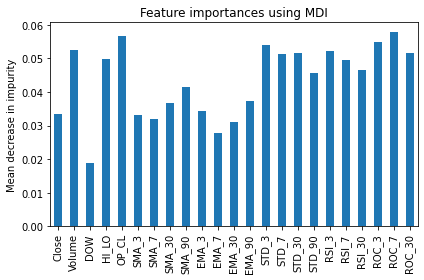

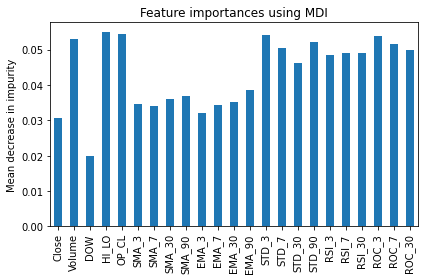

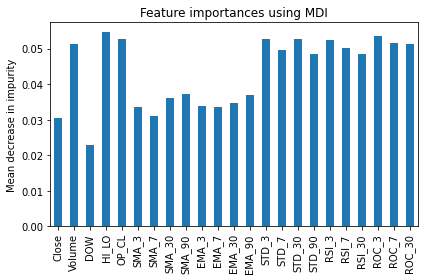

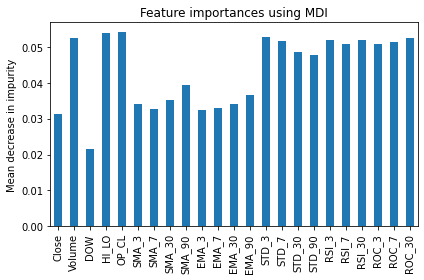

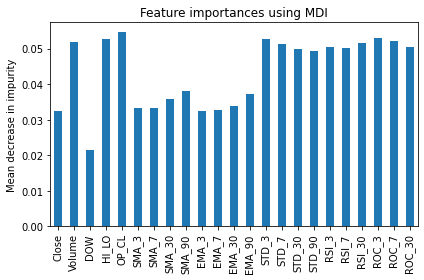

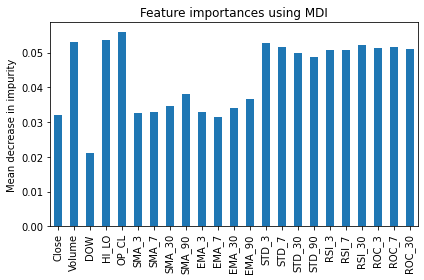

In [ ]:
select_features(X_train, Y_train.CL_1, X_test, Y_test.CL_1, 5)
select_features(X_train, Y_train.CL_1, X_test, Y_test.CL_1, 10)
select_features(X_train, Y_train.CL_1, X_test, Y_test.CL_1, 20)
select_features(X_train, Y_train.CL_1, X_test, Y_test.CL_1, 50)
select_features(X_train, Y_train.CL_1, X_test, Y_test.CL_1, 200)
select_features(X_train, Y_train.CL_1, X_test, Y_test.CL_1, 100)

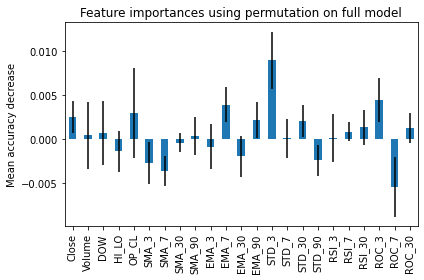

In [ ]:
from sklearn.inspection import permutation_importance
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, Y_train.CL_1)
result = permutation_importance(
    forest, X_test, Y_test.CL_1, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.Series(result.importances_mean, index=all_features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

As we can see from above there aren't many differences between the results, so we will take size of forest 50 going forward.

In [ ]:
def select_features(X_train, y_train, X_test, y_test, n):
  sel = SelectFromModel(RandomForestClassifier(n_estimators = n))
  sel.fit(X_train, y_train)
  selected_feat= X_train.columns[(sel.get_support())]
  #pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

  return selected_feat

In [ ]:
cfeatures1 = select_features(X_train, Y_train.CL_1, X_test, Y_test.CL_1, 50)
cfeatures3 = select_features(X_train, Y_train.CL_3, X_test, Y_test.CL_3, 50)
cfeatures7 = select_features(X_train, Y_train.CL_7, X_test, Y_test.CL_7, 50)
cfeatures30 = select_features(X_train, Y_train.CL_30, X_test, Y_test.CL_30, 50)

In [ ]:
print(cfeatures1)
print(cfeatures3)
print(cfeatures7)
print(cfeatures30)

Index(['Volume', 'HI_LO', 'OP_CL', 'STD_3', 'STD_7', 'STD_30', 'STD_90',
       'RSI_3', 'RSI_7', 'RSI_30', 'ROC_3', 'ROC_7', 'ROC_30'],
      dtype='object')
Index(['Volume', 'HI_LO', 'OP_CL', 'SMA_90', 'STD_3', 'STD_7', 'STD_30',
       'STD_90', 'RSI_3', 'RSI_7', 'RSI_30', 'ROC_3', 'ROC_7', 'ROC_30'],
      dtype='object')
Index(['Volume', 'SMA_30', 'SMA_90', 'EMA_30', 'EMA_90', 'STD_7', 'STD_30',
       'STD_90', 'RSI_30', 'ROC_7', 'ROC_30'],
      dtype='object')
Index(['SMA_7', 'SMA_30', 'SMA_90', 'EMA_7', 'EMA_30', 'EMA_90', 'STD_30',
       'STD_90'],
      dtype='object')


In [ ]:
def select_features_reg(X_train, y_train, X_test, y_test, n):
  sel = SelectFromModel(RandomForestRegressor(n_estimators = n))
  sel.fit(X_train, y_train)
  selected_feat= X_train.columns[(sel.get_support())]
  pd.Series(sel.estimator_.feature_importances_.ravel()).hist()
  return selected_feat

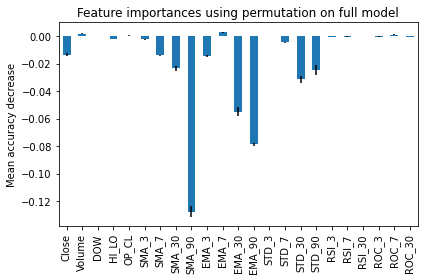

In [ ]:
forest = RandomForestRegressor(n_estimators = 30)
forest.fit(X_train, Y_train.REG_30)
result = permutation_importance(
    forest, X_test, Y_test.REG_30, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.Series(result.importances_mean, index=all_features)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Index(['Close', 'SMA_3', 'EMA_3', 'EMA_90'], dtype='object')
Index(['Close', 'SMA_3', 'EMA_3', 'EMA_90'], dtype='object')
Index(['Close', 'EMA_3', 'EMA_90'], dtype='object')
Index(['SMA_30', 'EMA_30', 'EMA_90'], dtype='object')


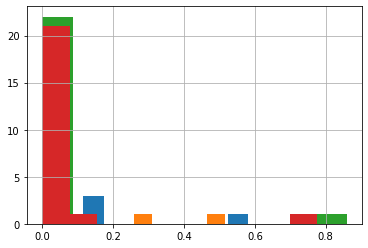

In [ ]:
rfeatures1 = select_features_reg(X_train, Y_train.REG_1, X_test, Y_test.REG_1, 50)
print(rfeatures1)
rfeatures3 = select_features_reg(X_train, Y_train.REG_3, X_test, Y_test.REG_3, 50)
print(rfeatures3)
rfeatures7 = select_features_reg(X_train, Y_train.REG_7, X_test, Y_test.REG_7, 50)
print(rfeatures7)
rfeatures30 = select_features_reg(X_train, Y_train.REG_30, X_test, Y_test.REG_30, 20)
print(rfeatures30)

## 4.2 Variance Inflation Factor (VIF) of Features

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def get_VIF(X):
  vif_data = pd.DataFrame()
  vif_data["feature"] = X.columns
  vif_data["VIF"] = [variance_inflation_factor(X.values, i)  for i in range(len(X.columns))]
  return vif_data

### CLASSIFICATION MODELS

**NEXT DAY**

In [ ]:
#1 day
vif_data = get_VIF(X_train[cfeatures1])
print(vif_data)

   feature         VIF
0   Volume    2.623807
1    HI_LO  105.732232
2    OP_CL    1.785914
3    STD_3    4.191770
4    STD_7    5.957033
5   STD_30    6.511389
6   STD_90    6.181955
7    RSI_3   53.865285
8    RSI_7  185.448216
9   RSI_30  228.177655
10   ROC_3    2.775486
11   ROC_7    3.686793
12  ROC_30    4.331661


In [ ]:
cf1 = list(cfeatures1)
cf1.remove('RSI_30')
cf1.remove('RSI_7')
vif_data = get_VIF(X_train[cf1])
print(vif_data)

   feature        VIF
0   Volume   2.613257
1    HI_LO   9.620760
2    OP_CL   1.654301
3    STD_3   4.189505
4    STD_7   5.942306
5   STD_30   6.469691
6   STD_90   6.176560
7    RSI_3  10.695891
8    ROC_3   2.748305
9    ROC_7   2.095139
10  ROC_30   1.316964


**3 DAY**

Removing values that have too high VIF iteratively until all factors are smaller than 10.

In [ ]:
#3 day
vif_data = get_VIF(X_train[cfeatures3])
print(vif_data)

   feature         VIF
0   Volume    2.625326
1    HI_LO  106.637355
2    OP_CL    1.786914
3   SMA_90    8.557730
4    STD_3    4.212316
5    STD_7    6.049015
6   STD_30    6.798347
7   STD_90    7.725158
8    RSI_3   53.874861
9    RSI_7  185.499507
10  RSI_30  228.240394
11   ROC_3    2.776251
12   ROC_7    3.686992
13  ROC_30    4.333442


In [ ]:
cf3 = list(cfeatures3)
cf3.remove('RSI_30')
cf3.remove('RSI_7')
vif_data = get_VIF(X_train[cf3])
print(vif_data)

   feature        VIF
0   Volume   2.614877
1    HI_LO  10.313563
2    OP_CL   1.655060
3   SMA_90   8.554958
4    STD_3   4.210237
5    STD_7   6.033535
6   STD_30   6.760464
7   STD_90   7.716120
8    RSI_3  10.695892
9    ROC_3   2.748925
10   ROC_7   2.095142
11  ROC_30   1.321550


**7 day**

In [ ]:
#7 day
vif_data = get_VIF(X_train[cfeatures7])
print(vif_data)

   feature          VIF
0   Volume     2.471066
1   SMA_30  6429.180993
2   SMA_90  3375.442271
3   EMA_30  8067.784170
4   EMA_90  6054.800132
5    STD_7     4.526310
6   STD_30     6.818916
7   STD_90     7.751062
8   RSI_30     2.991450
9    ROC_7     1.383605
10  ROC_30     2.281909


In [ ]:
cf7 = list(cfeatures7)
cf7.remove('SMA_30')
cf7.remove('EMA_30')
cf7.remove('EMA_90')

vif_data = get_VIF(X_train[cf7])
print(vif_data)

  feature       VIF
0  Volume  2.467865
1  SMA_90  8.435629
2   STD_7  4.508444
3  STD_30  6.756051
4  STD_90  7.672976
5  RSI_30  2.975064
6   ROC_7  1.322730
7  ROC_30  1.424726


**30 day**

In [ ]:
#30
vif_data = get_VIF(X_train[cfeatures30])
print(vif_data)

  feature           VIF
0   SMA_7  26716.453037
1  SMA_30  24816.358393
2  SMA_90   4339.419760
3   EMA_7  25859.946754
4  EMA_30  68096.367107
5  EMA_90   6029.917701
6  STD_30      5.773014
7  STD_90      7.519740


In [ ]:
cf30 = list(cfeatures30)
cf30.remove('SMA_7')
cf30.remove('EMA_30')
cf30.remove('SMA_30')
cf30.remove('SMA_90')
cf30.remove('EMA_90')

vif_data = get_VIF(X_train[cf30])
print(vif_data)

  feature       VIF
0   EMA_7  5.517662
1  STD_30  5.702034
2  STD_90  7.365844


### REGRESSION MODELS

In [ ]:
#1 day
vif_data = get_VIF(X_train[rfeatures1])
print(vif_data)
print()
#3 day
vif_data = get_VIF(X_train[rfeatures3])
print(vif_data)
print()
#7 day
vif_data = get_VIF(X_train[rfeatures7])
print(vif_data)
print()
#30
try:
  vif_data = get_VIF(X_train[rfeatures30])
  print(vif_data)
except:
  print(rfeatures30)

  feature            VIF
0   Close   14133.496707
1   SMA_3   77980.513900
2   EMA_3  139051.142985
3  EMA_90     180.013397

  feature            VIF
0   Close   14133.496707
1   SMA_3   77980.513900
2   EMA_3  139051.142985
3  EMA_90     180.013397

  feature          VIF
0   Close  8031.248182
1   EMA_3  8720.234633
2  EMA_90   166.567706

  feature          VIF
0  SMA_30  4625.447600
1  EMA_30  5202.817454
2  EMA_90   471.730569


Since in all regression models there aren't many important features and all of them have very high VIF factors, we will not eliminate any features in this step. We will also compare the performance of a model with features that are selected using the random forest and a model with all starting features.

In [ ]:
from torch import nn, optim
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset


# 5) Hyperparameter tuning

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import np_utils
from sklearn.model_selection import cross_val_score

In [ ]:
def baseline_model(layers, neurons, input, output, lr=0.01):
  m = Sequential()

  m.add(Dense(neurons, activation = 'relu', input_dim = input))

  for i in range(layers):
    m.add(Dense(units = neurons, activation = 'relu'))

  m.add(Dense(output, activation='softmax'))

  opt = keras.optimizers.Adam(learning_rate=lr)

  m.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return m

## Finding optimal number of layers

In [ ]:
train_X = X_train[cfeatures1].to_numpy()
train_y = Y_train['CL_1'].to_numpy()
test_X = X_test[cfeatures1].to_numpy()
test_y = Y_test['CL_1'].to_numpy()

In [ ]:
dummy_y = np_utils.to_categorical(train_y)
tst_y = np_utils.to_categorical(test_y)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

UNITS = 64
EPOCHS = 20
LEARNING_RATE = 0.01
train_loss = []
valid_loss = []

for i in range(1, 5):
  tr_loss = []
  v_loss = []
  print(i)

  for train_index, valid_index in tscv.split(train_X):
      X_tr, X_val = train_X[train_index], train_X[valid_index]
      y_tr, y_val = dummy_y[train_index], dummy_y[valid_index]

      model = baseline_model(i, UNITS, X_tr.shape[1], y_tr.shape[1], LEARNING_RATE)
      hist = model.fit(X_tr, y_tr, epochs = EPOCHS, verbose=0)

      tr_loss.append(hist.history['loss'][-1])

      ev = model.evaluate(X_val, y_val, verbose=0)
      v_loss.append(ev)

  train_loss.append(np.average(tr_loss))
  valid_loss.append(np.average(v_loss))

1
2
3
4


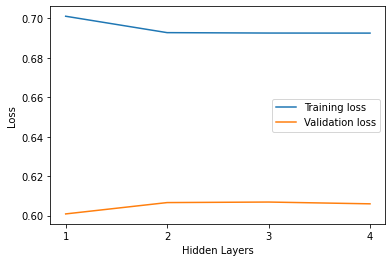

In [ ]:
units = np.arange(1,5)
plt.plot(units, train_loss, label='Training loss')
plt.plot(units, valid_loss, label='Validation loss')
plt.xlabel('Hidden Layers')
plt.ylabel('Loss')
plt.xticks([1,2,3,4])
plt.legend()
plt.show()

We determined 2 layers to be optimal.

## Finding optimal number of neurons per layer

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

LAYERS = 3
train_loss = []
valid_loss = []

for i in range(10,250,20):
  tr_loss = []
  v_loss = []
  print(i)

  for train_index, valid_index in tscv.split(train_X):
      X_tr, X_val = train_X[train_index], train_X[valid_index]
      y_tr, y_val = dummy_y[train_index], dummy_y[valid_index]

      model = baseline_model(layers=LAYERS, neurons=i, input=X_tr.shape[1], output=y_tr.shape[1], lr=LEARNING_RATE)
      hist = model.fit(X_tr, y_tr, epochs = EPOCHS, verbose=0)

      tr_loss.append(hist.history['loss'][-1])

      ev = model.evaluate(X_val, y_val, verbose=0)
      v_loss.append(ev)

  train_loss.append(np.average(tr_loss))
  valid_loss.append(np.average(v_loss))

10
30
50
70
90
110
130
150
170
190
210
230


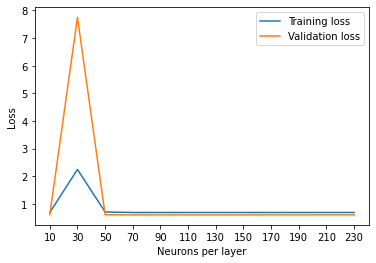

In [ ]:
units = np.arange(10,250,20)
plt.plot(units, train_loss, label='Training loss')
plt.plot(units, valid_loss, label='Validation loss')
plt.xlabel('Neurons per layer')
plt.ylabel('Loss')
plt.xticks(units)
plt.legend()
plt.show()

## Finding the optimal learning rate

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

LAYERS = 3
NEURONS = 50
train_loss = []
valid_loss = []

lrs = [0.1, 0.01, 0.001, 0.0001]

for i in lrs:
  tr_loss = []
  v_loss = []
  print(i)

  for train_index, valid_index in tscv.split(train_X):
      X_tr, X_val = train_X[train_index], train_X[valid_index]
      y_tr, y_val = dummy_y[train_index], dummy_y[valid_index]

      model = baseline_model(layers=LAYERS, neurons=NEURONS, input=X_tr.shape[1], output=y_tr.shape[1], lr=i)
      hist = model.fit(X_tr, y_tr, epochs = EPOCHS, verbose=0)

      tr_loss.append(hist.history['loss'][-1])

      ev = model.evaluate(X_val, y_val, verbose=0)
      v_loss.append(ev)

  train_loss.append(np.average(tr_loss))
  valid_loss.append(np.average(v_loss))

0.1
0.01
0.001
0.0001


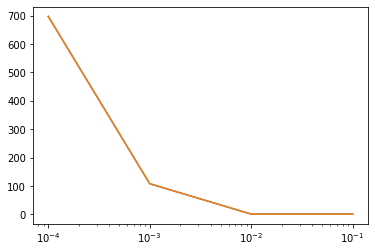

In [ ]:
plt.plot(lrs, train_loss, label='Training loss')
plt.plot(lrs, train_loss, label='Validation loss')

plt.gca().set_xscale('log')
plt.show()


# 6) Classification

### Next-day Price Prediction

In [ ]:
LAYERS = 2
NEURONS = 64
LEARNING_RATE = 0.1

In [ ]:
trainX = X_train[cfeatures1].to_numpy()
testX = X_test[cfeatures1].to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_1'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_1'].to_numpy())

In [ ]:
model = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 39276.5508 - accuracy: 0.5073
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6965 - accuracy: 0.5069
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6958 - accuracy: 0.5137
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6952 - accuracy: 0.5031
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6958 - accuracy: 0.5094
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6963 - accuracy: 0.5056
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6974 - accuracy: 0.5037
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6970 - accuracy: 0.4999
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6959 - accuracy: 0.5046
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6949 - ac

In [ ]:
results = model.evaluate(testX, testY)

88/88 [==============================] - 0s 1ms/step - loss: 0.7667 - accuracy: 0.5107


**Using all features**

In [ ]:
trainX = X_train.to_numpy()
testX = X_test.to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_1'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_1'].to_numpy())
model2 = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model2.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 35156.1406 - accuracy: 0.5082
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6989 - accuracy: 0.4954
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6963 - accuracy: 0.5017
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7010 - accuracy: 0.4961
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6981 - accuracy: 0.5064
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6992 - accuracy: 0.4922
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6965 - accuracy: 0.5069
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6955 - accuracy: 0.5087
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6960 - accuracy: 0.5065
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6959 - ac

In [ ]:
results = model2.evaluate(testX, testY)

88/88 [==============================] - 0s 1ms/step - loss: 0.7065 - accuracy: 0.4889


**Using only volume and closing price**

In [ ]:
trainX = X_train[['Close', 'Volume']].to_numpy()
testX = X_test[['Close', 'Volume']].to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_1'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_1'].to_numpy())
model3 = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model3.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 73714.7891 - accuracy: 0.5058
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6965 - accuracy: 0.5051
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6973 - accuracy: 0.5107
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6966 - accuracy: 0.5056
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6986 - accuracy: 0.5049
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6966 - accuracy: 0.5039
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6972 - accuracy: 0.5028
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6973 - accuracy: 0.5042
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6961 - accuracy: 0.5060
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6954 - ac

In [ ]:
results = model3.evaluate(testX, testY)

88/88 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5111


### 3 Day Horizon Price Prediction

In [ ]:
trainX = X_train[cfeatures3].to_numpy()
testX = X_test[cfeatures3].to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_3'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_3'].to_numpy())

In [ ]:
model3c = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model3c.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 54489.0742 - accuracy: 0.4935
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7003 - accuracy: 0.5035
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7021 - accuracy: 0.4974
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7038 - accuracy: 0.4924
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6996 - accuracy: 0.5026
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6983 - accuracy: 0.4972
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6976 - accuracy: 0.4920
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6998 - accuracy: 0.5078
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7020 - accuracy: 0.5021
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7001 - ac

In [ ]:
results = model3c.evaluate(testX, testY)

88/88 [==============================] - 0s 1ms/step - loss: 0.7115 - accuracy: 0.5365


**With all features included**

In [ ]:
trainX = X_train.to_numpy()
testX = X_test.to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_3'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_3'].to_numpy())

In [ ]:
model3c2 = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model3c2.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 47039.1836 - accuracy: 0.4969
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6964 - accuracy: 0.4983
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6971 - accuracy: 0.4933
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6966 - accuracy: 0.5003
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6977 - accuracy: 0.5040
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6968 - accuracy: 0.5017
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6968 - accuracy: 0.4963
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6991 - accuracy: 0.4933
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6956 - accuracy: 0.5008
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6957 - ac

In [ ]:
results = model3c2.evaluate(testX, testY)

88/88 [==============================] - 0s 2ms/step - loss: 0.8426 - accuracy: 0.5365


### 7 Day Horizon Price Prediction

In [ ]:
trainX = X_train[cfeatures7].to_numpy()
testX = X_test[cfeatures7].to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_7'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_7'].to_numpy())

In [ ]:
model7 = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model7.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 63031.0898 - accuracy: 0.5014
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6968 - accuracy: 0.5068
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6967 - accuracy: 0.5016
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6964 - accuracy: 0.5034
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.4971
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6973 - accuracy: 0.4961
Epoch 7/100
349/349 [==============================] - 1s 3ms/step - loss: 0.6967 - accuracy: 0.5088
Epoch 8/100
349/349 [==============================] - 1s 3ms/step - loss: 0.6970 - accuracy: 0.5041
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.5021
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6953 - ac

In [ ]:
results = model7.evaluate(testX, testY)

88/88 [==============================] - 0s 1ms/step - loss: 0.7442 - accuracy: 0.5494


Using all features instead of only the ones chosen by feature selection.

In [ ]:
trainX = X_train.to_numpy()
testX = X_test.to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_7'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_7'].to_numpy())

In [ ]:
model7c2 = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model7c2.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 40506.1250 - accuracy: 0.5079
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7038 - accuracy: 0.5043
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7025 - accuracy: 0.5122
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7006 - accuracy: 0.5004
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7042 - accuracy: 0.4900
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7054 - accuracy: 0.5054
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7004 - accuracy: 0.4961
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7001 - accuracy: 0.5061
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.7015 - accuracy: 0.4959
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6988 - ac

In [ ]:
results = model7c2.evaluate(testX, testY)

88/88 [==============================] - 78s 1ms/step - loss: 0.7081 - accuracy: 0.4506


### 30 Day Horizon Price Prediction

In [ ]:
trainX = X_train[cfeatures30].to_numpy()
testX = X_test[cfeatures30].to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_30'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_30'].to_numpy())

In [ ]:
model30 = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model30.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 1.6246 - accuracy: 0.5253
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6943 - accuracy: 0.5278
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5256
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6940 - accuracy: 0.5244
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6947 - accuracy: 0.5179
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6950 - accuracy: 0.5201
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6962 - accuracy: 0.5247
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6950 - accuracy: 0.5244
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6949 - accuracy: 0.5258
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6947 - accura

In [ ]:
results = model30.evaluate(testX, testY)

88/88 [==============================] - 0s 1ms/step - loss: 0.6823 - accuracy: 0.5928


**Using all features**

In [ ]:
trainX = X_train.to_numpy()
testX = X_test.to_numpy()

trainY = np_utils.to_categorical(Y_train['CL_30'].to_numpy())
testY = np_utils.to_categorical(Y_test['CL_30'].to_numpy())
model30c2 = baseline_model(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=trainY.shape[1], lr=LEARNING_RATE)

In [ ]:
model30c2.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 32973.7773 - accuracy: 0.5314
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6961 - accuracy: 0.5244
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6964 - accuracy: 0.5208
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6956 - accuracy: 0.5247
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.5174
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6957 - accuracy: 0.5193
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.5195
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6957 - accuracy: 0.5206
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6956 - accuracy: 0.5156
Epoch 10/100
349/349 [==============================] - 1s 2ms/step - loss: 0.6967 - ac

In [ ]:
results = model30c2.evaluate(testX, testY)

88/88 [==============================] - 0s 2ms/step - loss: 0.6829 - accuracy: 0.5931


# 7) Regression model

In [ ]:
def baseline_model_reg(layers, neurons, input, output, lr):
  m = Sequential()

  m.add(Dense(neurons, activation = 'relu', input_dim = input))

  for n in range(layers):
    m.add(Dense(units = neurons, activation = 'relu'))

  m.add(Dense(1))
  opt = keras.optimizers.Adam(learning_rate=lr)

  m.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse','mape'])
  return m

## Next Day Price Prediction

**Using features selected with random forest**

In [ ]:
trainX = X_train[rfeatures1].to_numpy()
testX = X_test[rfeatures1].to_numpy()

trainY = Y_train['REG_1'].to_numpy()
testY = Y_test['REG_1'].to_numpy()

In [ ]:
mod1r = baseline_model_reg(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=1, lr=LEARNING_RATE)

In [ ]:
mod1r.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 2ms/step - loss: 86.1589 - mse: 86.1589 - mape: 18.7083
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 3.5369 - mse: 3.5369 - mape: 7.5842
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 8.3770 - mse: 8.3770 - mape: 9.6278
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 3.7827 - mse: 3.7827 - mape: 6.8520
Epoch 5/100
349/349 [==============================] - 1s 3ms/step - loss: 2.3652 - mse: 2.3652 - mape: 5.6031
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 2.0715 - mse: 2.0715 - mape: 5.4336
Epoch 7/100
349/349 [==============================] - 1s 3ms/step - loss: 2.6830 - mse: 2.6830 - mape: 6.3195
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 3.4093 - mse: 3.4093 - mape: 6.7781
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 2.4713 - mse: 2.4713 - mape: 5.512

In [ ]:
mod1r.evaluate(testX, testY)

88/88 [==============================] - 0s 1ms/step - loss: 18.1929 - mse: 18.1929 - mape: 2.5431


[18.192943572998047, 18.192943572998047, 2.543125867843628]

In [ ]:
prediction1r = mod1r.predict(testX)
#prediction1 = scaler_close.inverse_transform(prediction)

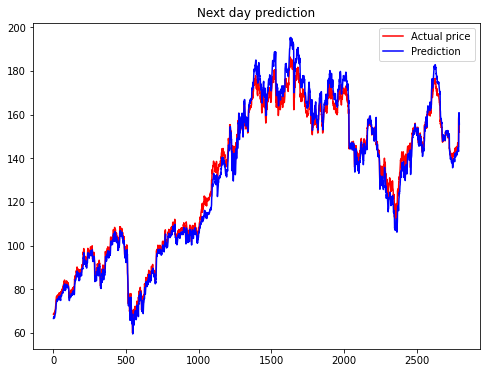

In [ ]:
time = np.arange(1, len(prediction1)+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(time, Y_test['REG_1'].to_numpy(), 'r-', label='Actual price')
plt.plot(time, prediction1r, 'b-', label='Prediction')
plt.title('Next day prediction')
plt.legend()
plt.show()

**Using all features**

In [ ]:
trainX = X_train.to_numpy()
testX = X_test.to_numpy()

trainY = Y_train['REG_1'].to_numpy()
testY = Y_test['REG_1'].to_numpy()

In [ ]:
mod1r2 = baseline_model_reg(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=1, lr=LEARNING_RATE)

In [ ]:
mod1r2.fit(trainX, trainY, epochs=50)

Epoch 1/50
349/349 [==============================] - 2s 3ms/step - loss: 98.3496 - mse: 98.3496 - mape: 27.5189
Epoch 2/50
349/349 [==============================] - 1s 3ms/step - loss: 8.5569 - mse: 8.5569 - mape: 12.8157
Epoch 3/50
349/349 [==============================] - 1s 3ms/step - loss: 5.7160 - mse: 5.7160 - mape: 10.5251
Epoch 4/50
349/349 [==============================] - 1s 3ms/step - loss: 4.3975 - mse: 4.3975 - mape: 8.9349
Epoch 5/50
349/349 [==============================] - 1s 3ms/step - loss: 5.1128 - mse: 5.1128 - mape: 9.8491
Epoch 6/50
349/349 [==============================] - 1s 3ms/step - loss: 4.1733 - mse: 4.1733 - mape: 8.6192
Epoch 7/50
349/349 [==============================] - 1s 3ms/step - loss: 4.8877 - mse: 4.8877 - mape: 9.3368
Epoch 8/50
349/349 [==============================] - 1s 3ms/step - loss: 2.2616 - mse: 2.2616 - mape: 6.1428
Epoch 9/50
349/349 [==============================] - 1s 3ms/step - loss: 3.9091 - mse: 3.9091 - mape: 8.4053
Epoch

In [ ]:
prediction1r2 = mod1r2.predict(testX)

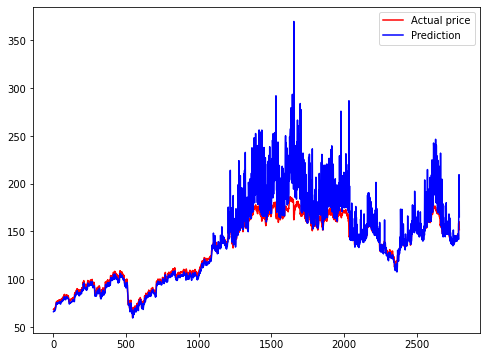

In [ ]:
time = np.arange(1, len(prediction1r2)+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(time, testY, 'r-', label='Actual price')
plt.plot(time, prediction1r2, 'b-', label='Prediction')
plt.legend()
plt.show()

## 3 Day Horizon Price Prediction




In [ ]:
import torch.nn.functional as F

In [ ]:
trainX = X_train[rfeatures3].to_numpy()
testX = X_test[rfeatures3].to_numpy()

trainY = Y_train['REG_3'].to_numpy()
testY = Y_test['REG_3'].to_numpy()

In [ ]:
mod3r = baseline_model_reg(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=1, lr=LEARNING_RATE)

In [ ]:
mod3r.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 2s 3ms/step - loss: 76.2539 - mse: 76.2539 - mape: 17.4362
Epoch 2/100
349/349 [==============================] - 1s 3ms/step - loss: 6.4489 - mse: 6.4489 - mape: 9.6277
Epoch 3/100
349/349 [==============================] - 1s 3ms/step - loss: 5.4755 - mse: 5.4755 - mape: 8.7805
Epoch 4/100
349/349 [==============================] - 1s 3ms/step - loss: 6.9028 - mse: 6.9028 - mape: 9.6786
Epoch 5/100
349/349 [==============================] - 1s 3ms/step - loss: 4.9648 - mse: 4.9648 - mape: 8.1622
Epoch 6/100
349/349 [==============================] - 1s 3ms/step - loss: 5.0296 - mse: 5.0296 - mape: 8.0787
Epoch 7/100
349/349 [==============================] - 1s 3ms/step - loss: 4.3691 - mse: 4.3691 - mape: 7.4160
Epoch 8/100
349/349 [==============================] - 1s 3ms/step - loss: 7.8179 - mse: 7.8179 - mape: 9.2638
Epoch 9/100
349/349 [==============================] - 1s 3ms/step - loss: 3.3785 - mse: 3.3785 - mape: 6.502

In [ ]:
prediction3r = mod3r.predict(testX)

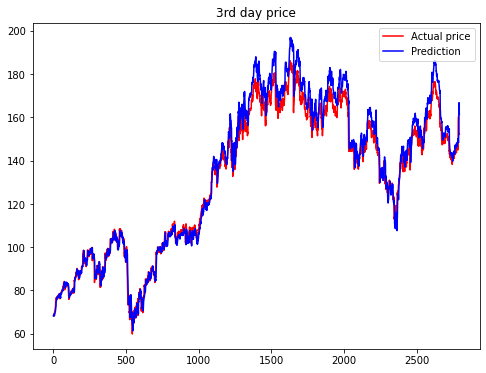

In [ ]:
time = np.arange(1, len(prediction)+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(time, testY, 'r-', label='Actual price')
plt.plot(time, prediction3r, 'b-', label='Prediction')
#plt.plot(time[-100:], prediction2[-100:], 'b-', label = 'Shifted prediction')
plt.legend()
plt.title('3rd day price')
plt.show()

#### All features included

In [ ]:
trainX = X_train.to_numpy()
testX = X_test.to_numpy()

trainY = Y_train['REG_3'].to_numpy()
testY = Y_test['REG_3'].to_numpy()

In [ ]:
mod3r2= baseline_model_reg(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=1, lr=LEARNING_RATE)

In [ ]:
mod3r2.fit(trainX, trainY, epochs=100)

349/349 [==============================] - 2s 3ms/step - loss: 143.8843 - mse: 143.8843 - mape: 30.5044
Epoch 2/100
349/349 [==============================] - 2s 5ms/step - loss: 16.1399 - mse: 16.1399 - mape: 15.7677
Epoch 3/100
349/349 [==============================] - 1s 3ms/step - loss: 8.1171 - mse: 8.1171 - mape: 12.1518
Epoch 4/100
349/349 [==============================] - 1s 4ms/step - loss: 7.6214 - mse: 7.6214 - mape: 11.7493
Epoch 5/100
349/349 [==============================] - 1s 3ms/step - loss: 5.2781 - mse: 5.2781 - mape: 8.9849
Epoch 6/100
349/349 [==============================] - 1s 3ms/step - loss: 6.5497 - mse: 6.5497 - mape: 10.7331
Epoch 7/100
349/349 [==============================] - 1s 3ms/step - loss: 5.0386 - mse: 5.0386 - mape: 8.5238
Epoch 8/100
349/349 [==============================] - 1s 3ms/step - loss: 5.0462 - mse: 5.0462 - mape: 8.7079
Epoch 9/100
349/349 [==============================] - 1s 3ms/step - loss: 5.3135 - mse: 5.3135 - mape: 9.1622
Ep

In [ ]:
prediction3r2 = mod3r2.predict(testX)

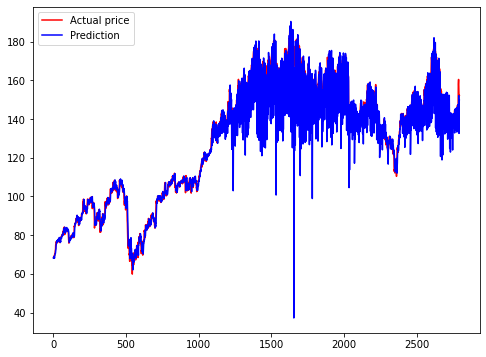

In [ ]:
time = np.arange(1, len(prediction3r2)+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(time, testY, 'r-', label='Actual price')
plt.plot(time, prediction3r2, 'b-', label='Prediction')
plt.legend()
plt.show()

## 7 Day Horizon Price Prediction

In [ ]:
trainX = X_train[rfeatures7].to_numpy()
testX = X_test[rfeatures7].to_numpy()

trainY = Y_train['REG_7'].to_numpy()
testY = Y_test['REG_7'].to_numpy()

In [ ]:
mod7r = baseline_model_reg(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=1, lr=LEARNING_RATE)

In [ ]:
mod7r.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 2s 3ms/step - loss: 92.4898 - mse: 92.4898 - mape: 18.0082
Epoch 2/100
349/349 [==============================] - 1s 3ms/step - loss: 5.9483 - mse: 5.9483 - mape: 7.4689
Epoch 3/100
349/349 [==============================] - 1s 3ms/step - loss: 6.9106 - mse: 6.9106 - mape: 9.0227
Epoch 4/100
349/349 [==============================] - 1s 3ms/step - loss: 7.0538 - mse: 7.0538 - mape: 8.9133
Epoch 5/100
349/349 [==============================] - 1s 4ms/step - loss: 6.8444 - mse: 6.8444 - mape: 8.6198
Epoch 6/100
349/349 [==============================] - 2s 5ms/step - loss: 7.0884 - mse: 7.0884 - mape: 8.8523
Epoch 7/100
349/349 [==============================] - 1s 3ms/step - loss: 8.0841 - mse: 8.0841 - mape: 9.9511
Epoch 8/100
349/349 [==============================] - 1s 3ms/step - loss: 6.9765 - mse: 6.9765 - mape: 8.5058
Epoch 9/100
349/349 [==============================] - 1s 3ms/step - loss: 6.0222 - mse: 6.0222 - mape: 7.340

In [ ]:
prediction7 = mod7r.predict(testX)

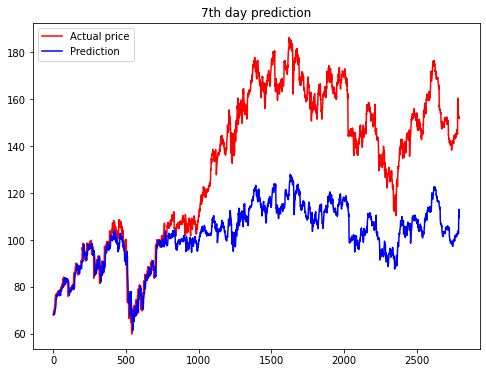

In [ ]:
time = np.arange(1, len(prediction)+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(time, testY, 'r-', label='Actual price')
plt.plot(time, prediction7, 'b-', label='Prediction')
plt.title('7th day prediction')
plt.legend()
plt.show()

#### All features included

In [ ]:
trainX = X_train.to_numpy()
testX = X_test.to_numpy()

trainY = Y_train['REG_7'].to_numpy()
testY = Y_test['REG_7'].to_numpy()
mod7r2 = baseline_model_reg(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=1, lr=LEARNING_RATE)

In [ ]:
mod7r2.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 2s 3ms/step - loss: 95.0191 - mse: 95.0191 - mape: 27.7750
Epoch 2/100
349/349 [==============================] - 1s 3ms/step - loss: 15.3068 - mse: 15.3068 - mape: 15.3357
Epoch 3/100
349/349 [==============================] - 1s 3ms/step - loss: 14.5079 - mse: 14.5079 - mape: 15.8176
Epoch 4/100
349/349 [==============================] - 1s 3ms/step - loss: 11.5505 - mse: 11.5505 - mape: 12.7225
Epoch 5/100
349/349 [==============================] - 1s 3ms/step - loss: 10.9001 - mse: 10.9001 - mape: 12.8462
Epoch 6/100
349/349 [==============================] - 1s 3ms/step - loss: 11.3101 - mse: 11.3101 - mape: 12.2998
Epoch 7/100
349/349 [==============================] - 1s 3ms/step - loss: 8.8847 - mse: 8.8847 - mape: 11.5237
Epoch 8/100
349/349 [==============================] - 1s 3ms/step - loss: 9.1534 - mse: 9.1534 - mape: 11.4471
Epoch 9/100
349/349 [==============================] - 1s 3ms/step - loss: 9.2384 - mse: 9.2

In [ ]:
prediction72 = mod7r2.predict(testX)

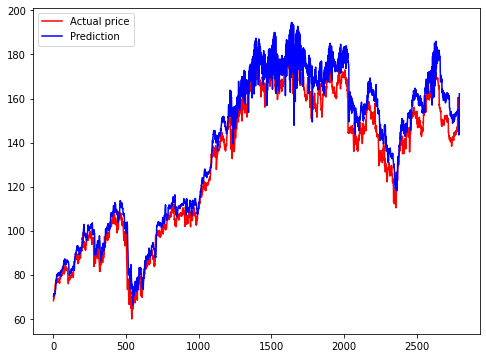

In [ ]:
time = np.arange(1, len(prediction72)+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(time, testY, 'r-', label='Actual price')
plt.plot(time, prediction72, 'b-', label='Prediction')
plt.legend()
plt.show()

## 30 Day Horizon Price Prediction

In [ ]:
trainX = X_train[rfeatures30].to_numpy()
testX = X_test[rfeatures30].to_numpy()

trainY = Y_train['REG_30'].to_numpy()
testY = Y_test['REG_30'].to_numpy()

In [ ]:
mod30r = baseline_model_reg(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=1, lr=LEARNING_RATE)

In [ ]:
mod30r.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 1s 3ms/step - loss: 102.1510 - mse: 102.1510 - mape: 24.4404
Epoch 2/100
349/349 [==============================] - 1s 2ms/step - loss: 28.7714 - mse: 28.7714 - mape: 16.8336
Epoch 3/100
349/349 [==============================] - 1s 2ms/step - loss: 24.2120 - mse: 24.2120 - mape: 13.8446
Epoch 4/100
349/349 [==============================] - 1s 2ms/step - loss: 23.1648 - mse: 23.1648 - mape: 14.4571
Epoch 5/100
349/349 [==============================] - 1s 2ms/step - loss: 19.8439 - mse: 19.8439 - mape: 12.7117
Epoch 6/100
349/349 [==============================] - 1s 2ms/step - loss: 21.9371 - mse: 21.9371 - mape: 13.4664
Epoch 7/100
349/349 [==============================] - 1s 2ms/step - loss: 21.3126 - mse: 21.3126 - mape: 13.2992
Epoch 8/100
349/349 [==============================] - 1s 2ms/step - loss: 21.4647 - mse: 21.4647 - mape: 13.6769
Epoch 9/100
349/349 [==============================] - 1s 2ms/step - loss: 29.9311 - m

In [ ]:
predict30 = mod30r.predict(testX)

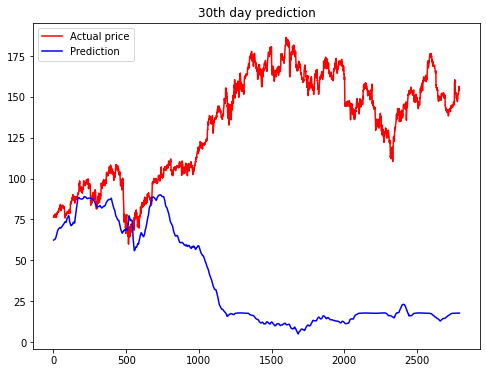

In [ ]:
time = np.arange(1, len(prediction)+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(time, testY, 'r-', label='Actual price')
plt.plot(time, predict30, 'b-', label='Prediction')
plt.legend()
plt.title('30th day prediction')
plt.show()

#### All features included

In [ ]:
trainX = X_train.to_numpy()
testX = X_test.to_numpy()

trainY = Y_train['REG_30'].to_numpy()
testY = Y_test['REG_30'].to_numpy()

In [ ]:
mod30r2 = baseline_model_reg(layers=LAYERS, neurons=NEURONS, input=trainX.shape[1], output=1, lr=LEARNING_RATE)

In [ ]:
mod30r2.fit(trainX, trainY, epochs=100)

Epoch 1/100
349/349 [==============================] - 2s 3ms/step - loss: 122.4975 - mse: 122.4975 - mape: 31.0151
Epoch 2/100
349/349 [==============================] - 1s 3ms/step - loss: 33.5179 - mse: 33.5179 - mape: 20.5694
Epoch 3/100
349/349 [==============================] - 1s 3ms/step - loss: 41.2231 - mse: 41.2231 - mape: 22.8845
Epoch 4/100
349/349 [==============================] - 1s 3ms/step - loss: 29.5796 - mse: 29.5796 - mape: 19.6125
Epoch 5/100
349/349 [==============================] - 1s 3ms/step - loss: 27.4391 - mse: 27.4391 - mape: 18.5447
Epoch 6/100
349/349 [==============================] - 1s 3ms/step - loss: 25.0373 - mse: 25.0373 - mape: 16.6973
Epoch 7/100
349/349 [==============================] - 1s 3ms/step - loss: 22.5312 - mse: 22.5312 - mape: 14.3993
Epoch 8/100
349/349 [==============================] - 1s 3ms/step - loss: 21.6469 - mse: 21.6469 - mape: 14.1591
Epoch 9/100
349/349 [==============================] - 1s 3ms/step - loss: 22.5504 - m

In [ ]:
predict302 = mod30r2.predict(testX)

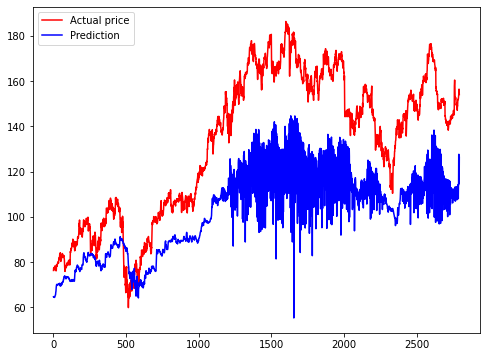

In [ ]:
time = np.arange(1, len(prediction)+1, 1)
plt.figure(figsize=(8, 6))
plt.plot(time, testY, 'r-', label='Actual price')
plt.plot(time, predict302, 'b-', label='Prediction')
plt.legend()
plt.show()

Plotting all together

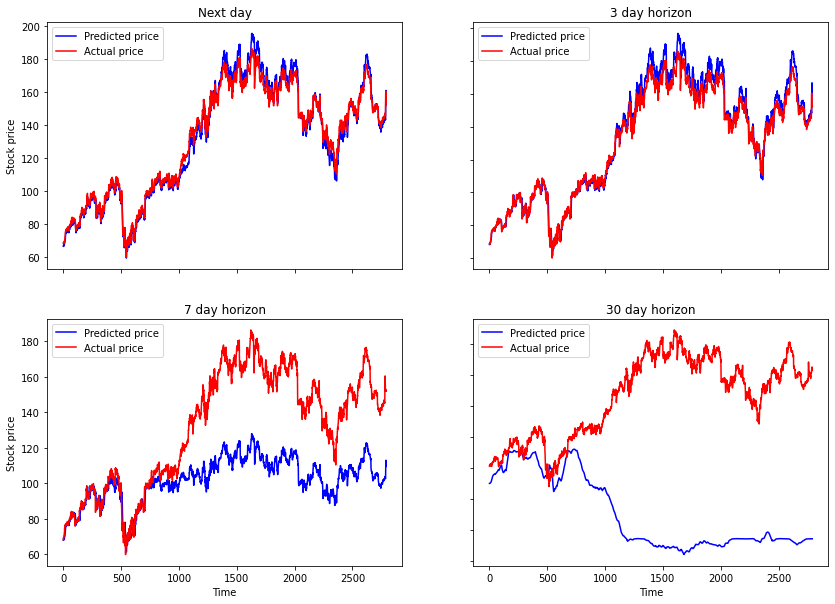

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))
time1 = np.arange(len(prediction1r))
axs[0, 0].plot(time1, prediction1r, color='blue', label='Predicted price')
axs[0, 0].plot(time1, Y_test['REG_1'].to_numpy(), color='red', label='Actual price')
axs[0, 0].set_title('Next day')

time3 = np.arange(len(prediction3r))
axs[0, 1].plot(time3, prediction3r, color='blue', label='Predicted price')
axs[0, 1].plot(time3, Y_test['REG_3'].to_numpy(), color='red', label='Actual price')
axs[0, 1].set_title('3 day horizon')

time7 = np.arange(len(prediction7))
axs[1, 0].plot(time7, prediction7, color='blue', label='Predicted price')
axs[1, 0].plot(time7, Y_test['REG_7'].to_numpy(), color='red', label='Actual price')
axs[1, 0].set_title('7 day horizon')

time30 = np.arange(len(predict30))
axs[1, 1].plot(time30, predict30, color='blue', label='Predicted price')
axs[1, 1].plot(time30, Y_test['REG_30'].to_numpy(), color='red', label='Actual price')
axs[1, 1].set_title('30 day horizon')


for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Stock price')
    ax.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

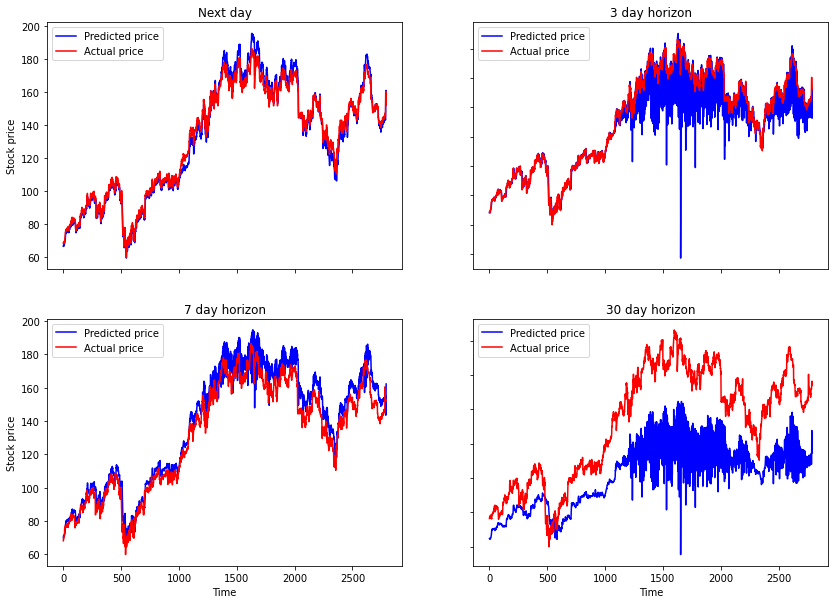

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))
time1 = np.arange(len(prediction1r2))
axs[0, 0].plot(time1, prediction1r, color='blue', label='Predicted price')
axs[0, 0].plot(time1, Y_test['REG_1'].to_numpy(), color='red', label='Actual price')
axs[0, 0].set_title('Next day')

time3 = np.arange(len(prediction3r2))
axs[0, 1].plot(time3, prediction3r2, color='blue', label='Predicted price')
axs[0, 1].plot(time3, Y_test['REG_3'].to_numpy(), color='red', label='Actual price')
axs[0, 1].set_title('3 day horizon')

time7 = np.arange(len(prediction72))
axs[1, 0].plot(time7, prediction72, color='blue', label='Predicted price')
axs[1, 0].plot(time7, Y_test['REG_7'].to_numpy(), color='red', label='Actual price')
axs[1, 0].set_title('7 day horizon')

time30 = np.arange(len(predict302))
axs[1, 1].plot(time30, predict302, color='blue', label='Predicted price')
axs[1, 1].plot(time30, Y_test['REG_30'].to_numpy(), color='red', label='Actual price')
axs[1, 1].set_title('30 day horizon')


for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Stock price')
    ax.legend()

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()